## Init notebook

This is run once.

## Preliminaries

In [1]:
# Load supporting functions.
import sys
sys.path.append('../')
from src import *

import quantus

/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Import libraries.
import torch
import os
from tqdm import tqdm
import joblib

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

Using device: NVIDIA TITAN RTX


## Run Experiments

In [3]:
# Define all the hyperparameters here
# Set the paramters marked with TODO to reproduce paper results
savepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/tmp2" #TODO Path to save results
dataset_name = "imagenet"
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet" #TODO Path to imagenet dataset
labelmap_path = "../src/label_map_imagenet.json"
model_names = ["vgg16", "resnet18"]
xai_methods = [
   "SmoothGrad",
   "IntegratedGradients",
   "LRP-Eps",
   "LRP-Z+",
   "Guided-Backprop",
   "Gradient",
   "Saliency"
] #TODO
nr_test_samples = 1000
smprt_nr_samples = [1, 20, 50]#, 300] #TODO: careful, this may take a while especially for 300 samples
smprt_noise_magnitude = 0.1
layer_orders = ["bottom_up", "top_down"]
eval_normalise = True
batch_size = 32
shuffle = False

recompute_results = False # Set this to False to only plot already computed results

linewidth=2.5

In [4]:
os.makedirs(savepath, exist_ok=True)

# Get Dataset
# Prepare transforms
transform = get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = batch_size,
    shuffle = False,
)

Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 10
Preparing dataloaders...


In [5]:
"""This module contains the implementation of the Smooth Model Parameter Randomisation Test metric."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

import sys
import warnings
from typing import (
    Any,
    Callable,
    Collection,
    Dict,
    List,
    Optional,
    Union,
    Tuple,
    Generator,
    Iterable,
)
from importlib import util

import numpy as np
import quantus
from tqdm.auto import tqdm
from sklearn.utils import gen_batches
from scipy import stats

from quantus.functions.similarity_func import correlation_spearman
from quantus.helpers import asserts, warn, utils
from quantus.helpers.enums import (
    DataType,
    EvaluationCategory,
    ModelType,
    ScoreDirection,
)
from quantus.helpers.model.model_interface import ModelInterface
from quantus.metrics.base import Metric

if sys.version_info >= (3, 8):
    from typing import final
else:
    from typing_extensions import final

if util.find_spec("torch"):
    import torch


@final
class SmoothMPRT(Metric):
    """
    Implementation of the Smooth MPRT by Hedström et al., 2023.

    The Smooth Model Parameter Randomisation adds a "denoising" preprocessing step to the original MPRT, 
    where the explanations are averaged over N noisy samples before the similarity between the original- 
    and fully random model's explanations is measured.

    References:
        1) Hedström, Anna, et al. "Sanity Checks Revisited: An Exploration to Repair the Model Parameter
        Randomisation Test." XAI in Action: Past, Present, and Future Applications. 2023.

    Attributes:
        -  _name: The name of the metric.
        - _data_applicability: The data types that the metric implementation currently supports.
        - _models: The model types that this metric can work with.
        - score_direction: How to interpret the scores, whether higher/ lower values are considered better.
        - evaluation_category: What property/ explanation quality that this metric measures.
    """

    name = "Smooth Model Parameter Randomisation Test"
    data_applicability = {DataType.IMAGE, DataType.TIMESERIES, DataType.TABULAR}
    model_applicability = {ModelType.TORCH, ModelType.TF}
    score_direction = ScoreDirection.LOWER
    evaluation_category = EvaluationCategory.RANDOMISATION

    def __init__(
        self,
        similarity_func: Optional[Callable] = None,
        layer_order: str = "bottom_up",
        seed: int = 42,
        nr_samples: int = 50,
        noise_magnitude: float = 0.1,
        return_average_correlation: bool = False,
        return_last_correlation: bool = False,
        skip_layers: bool = False,
        abs: bool = True,
        normalise: bool = True,
        normalise_func: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        normalise_func_kwargs: Optional[Dict[str, Any]] = None,
        return_aggregate: bool = False,
        aggregate_func: Optional[Callable] = None,
        default_plot_func: Optional[Callable] = None,
        disable_warnings: bool = False,
        display_progressbar: bool = False,
        **kwargs,
    ):
        """
        Parameters
        ----------
        similarity_func: callable
            Similarity function applied to compare input and perturbed input, default=correlation_spearman.
        layer_order: string
            Indicated whether the model is randomized cascadingly or independently.
            Set order=top_down for cascading randomization, set order=independent for independent randomization,
            default="independent".
        seed: integer
            Seed used for the random generator, default=42.
        nr_samples: integer
            The number of samples used to compute the average (denoised) explanations, default=50.
            The default value is set based on ImageNet experiment in the reference paper.
            Please update the value according to your use case.
        noise_magnitude: float
            The magnitude of the noise added to the input, default=0.1.
            The default value is set based on ImageNet experiment in the reference paper.
            Please update the value according to your use case.
        return_average_correlation: boolean
            Indicates whether to return one float per sample, computing the average
            correlation coefficient across the layers for a given sample.
        return_last_correlation: boolean
            Indicates whether to return one float per sample, computing the explanation
            correlation coefficient for the full model randomisation (not layer-wise) of a sample.
        skip_layers: boolean
            Indicates if explanation similarity should be computed only once; between the
            original and fully randomised model, instead of in a layer-by-layer basis.
        abs: boolean
            Indicates whether absolute operation is applied on the attribution, default=True.
        normalise: boolean
            Indicates whether normalise operation is applied on the attribution, default=True.
        normalise_func: callable
            Attribution normalisation function applied in case normalise=True.
            If normalise_func=None, the default value is used, default=normalise_by_max.
        normalise_func_kwargs: dict
            Keyword arguments to be passed to normalise_func on call, default={}.
        return_aggregate: boolean
            Indicates if an aggregated score should be computed over all instances.
        aggregate_func: callable
            Callable that aggregates the scores given an evaluation call.
        default_plot_func: callable
            Callable that plots the metrics result.
        disable_warnings: boolean
            Indicates whether the warnings are printed, default=False.
        display_progressbar: boolean
            Indicates whether a tqdm-progress-bar is printed, default=False.
        kwargs: optional
            Keyword arguments.
        """

        super().__init__(
            abs=abs,
            normalise=normalise,
            normalise_func=normalise_func,
            normalise_func_kwargs=normalise_func_kwargs,
            return_aggregate=return_aggregate,
            aggregate_func=aggregate_func,
            default_plot_func=default_plot_func,
            display_progressbar=display_progressbar,
            disable_warnings=disable_warnings,
            **kwargs,
        )

        # Save metric-specific attributes.
        if similarity_func is None:
            similarity_func = correlation_spearman
        self.similarity_func = similarity_func
        self.layer_order = layer_order
        self.seed = seed
        self.nr_samples = nr_samples
        self.noise_magnitude = noise_magnitude
        self.return_average_correlation = return_average_correlation
        self.return_last_correlation = return_last_correlation
        self.skip_layers = skip_layers

        # Results are returned/saved as a dictionary not like in the super-class as a list.
        self.evaluation_scores = {}

        # Asserts and warnings.
        if self.return_average_correlation and self.return_last_correlation:
            raise ValueError(
                f"Both 'return_average_correlation' and 'return_last_correlation' cannot be set to 'True'. "
                f"Set both to 'False' or one of the attributes to 'True'."
            )
        if self.return_average_correlation and self.skip_layers:
            raise ValueError(
                f"Both 'return_average_correlation' and 'skip_layers' cannot be set to 'True'. "
                f"You need to calculate the explanation correlation at all layers in order "
                f"to compute the average correlation coefficient on all layers."
            )
        asserts.assert_layer_order(layer_order=self.layer_order)
        if not self.disable_warnings:
            warn.warn_parameterisation(
                metric_name=self.__class__.__name__,
                sensitive_params=(
                    "similarity metric 'similarity_func' and the order of "
                    "the layer randomisation 'layer_order', the number of samples 'nr_samples', and"
                    " the magnitude of noise 'noise_magnitude' "
                ),
                citation=(
                    'Hedström, Anna, et al. "Sanity Checks Revisited: An Exploration to Repair'
                    ' the Model Parameter Randomisation Test." XAI in Action: Past, Present, '
                    "and Future Applications. 2023."
                ),
            )

    def __call__(
        self,
        model,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        a_batch: Optional[np.ndarray] = None,
        s_batch: Optional[np.ndarray] = None,
        channel_first: Optional[bool] = None,
        explain_func: Optional[Callable] = None,
        explain_func_kwargs: Optional[Dict] = None,
        model_predict_kwargs: Optional[Dict] = None,
        softmax: Optional[bool] = False,
        device: Optional[str] = None,
        batch_size: int = 64,
        **kwargs,
    ) -> Union[List[float], float, Dict[str, List[float]], Collection[Any]]:
        """
        This implementation represents the main logic of the metric and makes the class object callable.
        It completes instance-wise evaluation of explanations (a_batch) with respect to input data (x_batch),
        output labels (y_batch) and a torch or tensorflow model (model).

        Calls general_preprocess() with all relevant arguments, calls
        () on each instance, and saves results to evaluation_scores.
        Calls custom_postprocess() afterwards. Finally returns evaluation_scores.

        The content of evaluation_scores will be appended to all_evaluation_scores (list) at the end of
        the evaluation call.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        channel_first: boolean, optional
            Indicates of the image dimensions are channel first, or channel last.
            Inferred from the input shape if None.
        explain_func: callable
            Callable generating attributions.
        explain_func_kwargs: dict, optional
            Keyword arguments to be passed to explain_func on call.
        model_predict_kwargs: dict, optional
            Keyword arguments to be passed to the model's predict method.
        softmax: boolean
            Indicates whether to use softmax probabilities or logits in model prediction.
            This is used for this __call__ only and won't be saved as attribute. If None, self.softmax is used.
        device: string
            Indicated the device on which a torch.Tensor is or will be allocated: "cpu" or "gpu".
        kwargs: optional
            Keyword arguments.

        Returns
        -------
        evaluation_scores: list
            a list of Any with the evaluation scores of the concerned batch.

        Examples:
        --------
            # Minimal imports.
            >> import quantus
            >> from quantus import LeNet
            >> import torch

            # Enable GPU.
            >> device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Load a pre-trained LeNet classification model (architecture at quantus/helpers/models).
            >> model = LeNet()
            >> model.load_state_dict(torch.load("tutorials/assets/pytests/mnist_model"))

            # Load MNIST datasets and make loaders.
            >> test_set = torchvision.datasets.MNIST(root='./sample_data', download=True)
            >> test_loader = torch.utils.data.DataLoader(test_set, batch_size=24)

            # Load a batch of inputs and outputs to use for XAI evaluation.
            >> x_batch, y_batch = iter(test_loader).next()
            >> x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

            # Generate Saliency attributions of the test set batch of the test set.
            >> a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1)
            >> a_batch_saliency = a_batch_saliency.cpu().numpy()

            # Initialise the metric and evaluate explanations by calling the metric instance.
            >> metric = Metric(abs=True, normalise=False)
            >> scores = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch_saliency)
        """

        # Run deprecation warnings.
        warn.deprecation_warnings(kwargs)
        warn.check_kwargs(kwargs)
        self.batch_size = batch_size
        self.device = device

        if not isinstance(channel_first, bool):  # None is not a boolean instance.
            self.channel_first = utils.infer_channel_first(x_batch)

        data = self.general_preprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
            custom_batch=None,
            channel_first=channel_first,
            explain_func=explain_func,
            explain_func_kwargs=explain_func_kwargs,
            model_predict_kwargs=model_predict_kwargs,
            softmax=softmax,
            device=device,
        )
        model: ModelInterface = data["model"]  # type: ignore
        # Here _batch refers to full dataset.
        x_full_dataset = data["x_batch"]
        y_full_dataset = data["y_batch"]
        a_full_dataset = data["a_batch"]

        # Results are returned/saved as a dictionary not as a list as in the super-class.
        self.evaluation_scores = {}

        # Get number of iterations from number of layers.
        n_layers = model.random_layer_generator_length
        pbar = tqdm(
            total=n_layers * len(x_full_dataset), disable=not self.display_progressbar
        )
        if self.display_progressbar:
            # Set property to False, so we display only 1 pbar.
            self._display_progressbar = False

        with pbar as pbar:
            for l_ix, (layer_name, random_layer_model) in enumerate(
                model.get_random_layer_generator(order=self.layer_order, seed=self.seed)
            ):
                pbar.desc = layer_name

                # Skip layers if computing delta.
                if self.skip_layers and (l_ix + 1) < n_layers:
                    continue

                if l_ix == 0:

                    # Generate explanations on original model in batches.
                    a_original_generator = self.generate_explanations(
                        model.get_model(),
                        x_full_dataset,
                        y_full_dataset,
                        **kwargs,
                    )

                    # Compute the similarity of explanations of the original model.
                    self.evaluation_scores["original"] = []
                    for a_batch, a_batch_original in zip(
                        self.generate_a_batches(a_full_dataset), a_original_generator
                    ):
                        for a_instance, a_instance_original in zip(
                            a_batch, a_batch_original
                        ):
                            score = self.evaluate_instance(
                                model=model,
                                x=None,
                                y=None,
                                s=None,
                                a=a_instance,
                                a_perturbed=a_instance_original,
                            )
                            # Save similarity scores in a result dictionary.
                            self.evaluation_scores["original"].append(score)
                            pbar.update(1)

                self.evaluation_scores[layer_name] = []

                # Generate explanations on perturbed model in batches.
                a_perturbed_generator = self.generate_explanations(
                    random_layer_model,
                    x_full_dataset,
                    y_full_dataset,
                    **kwargs,
                )

                # Compute the similarity of explanations of the perturbed model.
                for a_batch, a_batch_perturbed in zip(
                    self.generate_a_batches(a_full_dataset), a_perturbed_generator
                ):
                    for a_instance, a_instance_perturbed in zip(a_batch, a_batch_perturbed):
                        score = self.evaluate_instance(
                            model=random_layer_model,
                            x=None,
                            y=None,
                            s=None,
                            a=a_instance,
                            a_perturbed=a_instance_perturbed,
                        )
                        self.evaluation_scores[layer_name].append(score)
                        pbar.update(1)

        if self.return_average_correlation:
            self.evaluation_scores = self.recompute_average_correlation_per_sample()

        elif self.return_last_correlation:
            self.evaluation_scores = self.recompute_last_correlation_per_sample()

        if self.return_aggregate:
            assert self.return_average_correlation or self.return_last_correlation, (
                "Set 'return_average_correlation' or 'return_last_correlation'"
                " to True in order to compute the aggregate evaluation results."
            )
            self.evaluation_scores = [self.aggregate_func(self.evaluation_scores)]

        # Return all_evaluation_scores according to Quantus.
        self.all_evaluation_scores.append(self.evaluation_scores)

        return self.evaluation_scores

    def recompute_average_correlation_per_sample(
        self,
    ) -> List[float]:

        assert isinstance(self.evaluation_scores, dict), (
            "To compute the average correlation coefficient per sample for "
            "enhanced Model Parameter Randomisation Test, 'evaluation_scores' "
            "must be of type dict."
        )
        layer_length = len(
            self.evaluation_scores[list(self.evaluation_scores.keys())[0]]
        )
        results: Dict[int, list] = {sample: [] for sample in range(layer_length)}

        for sample in results:
            for layer in self.evaluation_scores:
                if layer == "orig":
                    continue
                results[sample].append(float(self.evaluation_scores[layer][sample]))
            results[sample] = np.mean(results[sample])

        corr_coeffs = np.array(list(results.values())).flatten().tolist()

        return corr_coeffs

    def recompute_last_correlation_per_sample(
        self,
    ) -> List[float]:

        assert isinstance(self.evaluation_scores, dict), (
            "To compute the last correlation coefficient per sample for "
            "enhanced Model Parameter Randomisation Test, 'evaluation_scores' "
            "must be of type dict."
        )
        # Return the correlation coefficient of the fully randomised model
        # (excluding the non-randomised correlation).
        corr_coeffs = list(self.evaluation_scores.values())[-1]
        corr_coeffs = [float(c) for c in corr_coeffs]
        return corr_coeffs

    def evaluate_instance(
        self,
        model: ModelInterface,
        x: Optional[np.ndarray],
        y: Optional[np.ndarray],
        a: Optional[np.ndarray],
        s: Optional[np.ndarray],
        a_perturbed: Optional[np.ndarray] = None,
    ) -> float:
        """
        Evaluate instance gets model and data for a single instance as input and returns the evaluation result.

        Parameters
        ----------
        model: ModelInterface
            A ModelInteface that is subject to explanation.
        x: np.ndarray
            The input to be evaluated on an instance-basis.
        y: np.ndarray
            The output to be evaluated on an instance-basis.
        a: np.ndarray
            The explanation to be evaluated on an instance-basis.
        s: np.ndarray
            The segmentation to be evaluated on an instance-basis.
        a_perturbed: np.ndarray
            The perturbed attributions.

        Returns
        -------
        float
            The evaluation results.
        """
        # Flatten the arrays for comparison and check constancy.
        a_flat = a.flatten()
        a_perturbed_flat = a_perturbed.flatten()

        try:
            return self.similarity_func(a_perturbed_flat, a_flat)
        except Exception as e:
            print(f"Encountered exception: {e} in similarity measure calculation")
            warnings.warn(
                "Setting similarity output to 1.",
                UserWarning,
            )
            return 1.0

        # Compute similarity measure.
        return self.similarity_func(a_perturbed_flat, a_flat)

    def custom_preprocess(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        a_batch: Optional[np.ndarray],
        **kwargs,
    ) -> Optional[Dict[str, np.ndarray]]:
        """
        Implementation of custom_preprocess_batch.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model e.g., torchvision.models that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        kwargs:
            Unused.
        Returns
        -------
        None
        """
        # Additional explain_func assert, as the one in general_preprocess()
        # won't be executed when a_batch != None.
        asserts.assert_explain_func(explain_func=self.explain_func)
        if a_batch is not None:  # Just to silence mypy warnings
            return None

        a_batch_chunks = []
        for a_chunk in self.generate_explanations(model, x_batch, y_batch):
            a_batch_chunks.extend(a_chunk)
        return dict(a_batch=np.asarray(a_batch_chunks))

    def generate_explanations(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        **kwargs,
    ) -> Generator[np.ndarray, None, None]:
        """
        Iterate over dataset in batches and generate explanations for complete dataset.
        Parameters
        ----------
        model: ModelInterface
            A ModelInterface that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        kwargs: optional, dict
            List of hyperparameters.

        Returns
        -------
        a_batch:
            Batch of explanations ready to be evaluated.
        """
        for i in gen_batches(len(x_batch), self.batch_size):
            x = x_batch[i.start : i.stop]
            y = y_batch[i.start : i.stop]
            a = self.explain_smooth_batch(
                model=model,
                x_batch=x,
                y_batch=y,
                **kwargs,
            )
            yield a

    def generate_a_batches(self, a_full_dataset):
        for batch in gen_batches(len(a_full_dataset), self.batch_size):
            yield a_full_dataset[batch.start : batch.stop]

    def evaluate_batch(self, *args, **kwargs):
        raise RuntimeError(
            "`evaluate_batch` must never be called for `Model Parameter Randomisation Test`."
        )

    def explain_smooth_batch(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        **kwargs,
    ) -> np.ndarray:
        """
        Compute explanations, normalise and take absolute (if was configured so during metric initialization.)
        This method should primarily be used if you need to generate additional explanation
        in metrics body. It encapsulates typical for Quantus pre- and postprocessing approach.
        It will do few things:
            - call model.shape_input (if ModelInterface instance was provided)
            - unwrap model (if ModelInterface instance was provided)
            - add noise to input and call explain_func via explain_smooth_batch_numpy
            - expand attribution channel
            - (optionally) normalise a_batch
            - (optionally) take np.abs of a_batch

        Parameters
        -------
        model:
            A model that is subject to explanation.
        x_batch:
            A np.ndarray which contains the input data that are explained.
        y_batch:
            A np.ndarray which contains the output labels that are explained.
        kwargs: optional, dict
            List of hyperparameters.

        Returns
        -------
        a_batch:
            Batch of explanations ready to be evaluated.
        """
        if isinstance(model, ModelInterface):
            # Sometimes the model is our wrapper, but sometimes raw Keras/Torch model.
            x_batch = model.shape_input(
                x=x_batch,
                shape=x_batch.shape,
                channel_first=True,
                batched=True,
            )
            model = model.get_model()

        # Set noise.
        dims = tuple(range(1, x_batch.ndim))
        std = self.noise_magnitude * (
            x_batch.max(axis=dims, keepdims=True)
            - x_batch.min(axis=dims, keepdims=True)
        )
        a_batch_smooth = self.explain_smooth_batch_numpy(
            model=model, x_batch=x_batch, y_batch=y_batch, std=std, **kwargs
        )

        a_batch_smooth = utils.expand_attribution_channel(a_batch_smooth, x_batch)
        asserts.assert_attributions(x_batch=x_batch, a_batch=a_batch_smooth)

        # Normalise and take absolute values of the attributions, if configured during metric instantiation.
        if self.normalise:
            a_batch_smooth = self.normalise_func(a_batch_smooth)

        if self.abs:
            a_batch_smooth = np.abs(a_batch_smooth)

        return a_batch_smooth

    def explain_smooth_batch_numpy(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        std: float,
        **kwargs,
    ) -> np.ndarray:
        """
        Compute explanations, normalise and take absolute (if was configured so during metric initialization.)
        This method should primarily be used if you need to generate additional explanation
        in metrics body. It encapsulates typical for Quantus pre- and postprocessing approach.
        It will do few things:
            - call model.shape_input (if ModelInterface instance was provided)
            - unwrap model (if ModelInterface instance was provided)
            - call explain_func
            - expand attribution channel

        Parameters
        -------
        model:
            A model that is subject to explanation.
        x_batch:
            A np.ndarray which contains the input data that are explained.
        y_batch:
            A np.ndarray which contains the output labels that are explained.
        std : float
            Standard deviation of the Gaussian noise.
        kwargs: optional, dict
            List of hyperparameters.

        Returns
        -------
        a_batch:
            Batch of explanations ready to be evaluated.
        """
        a_batch_smooth = None
        for n in range(self.nr_samples):
            # the last epsilon is defined as zero to compute the true output,
            # and have SmoothGrad w/ n_iter = 1 === gradient
            if n == self.nr_samples - 1:
                epsilon = np.zeros_like(x_batch)
            else:
                epsilon = np.random.randn(*x_batch.shape) * std
            a_batch = quantus.explain(model, x_batch + epsilon, y_batch, **self.explain_func_kwargs)
            if a_batch_smooth is None:
                a_batch_smooth = a_batch / self.nr_samples
            else:
                a_batch_smooth += a_batch / self.nr_samples

        return a_batch_smooth

In [6]:
# Generate SmoothMPRT Results
if recompute_results:

    for model_name in model_names:

        # Prepare model
        model = get_model(model_name, device)
        model.eval()

        XAI_METHOD_KWARGS = setup_xai_methods_zennit(xai_methods, model, device)

        for layer_order in layer_orders:

            print(f"Computing accuracy-scores with for model {model_name} with {layer_order} order")

            # Compute Accuracy
            accuracy_scores = {}
            n_layers = len(list(get_random_layer_generator(model, order=layer_order)))
            model_iterator = tqdm(
                get_random_layer_generator(model, order=layer_order),
                total=n_layers,
                disable=True,
            )

            for l_ix, (layer_name, random_layer_model) in enumerate(model_iterator):

                if l_ix == 0:
                    _, _, accuracy_scores["orig"] = eval_accuracy(model, loader, device)
                    accuracy_scores["orig"] = float(accuracy_scores["orig"])
                _, _, accuracy_scores[layer_name] = eval_accuracy(random_layer_model, loader, device)
                accuracy_scores[layer_name] = float(accuracy_scores[layer_name])

            filepath = os.path.join(savepath, f"accuracy--{model_name}--{layer_order}.joblib")
            joblib.dump(accuracy_scores, filepath)

            # Compute sMPRT Scores
            for nr_samples in smprt_nr_samples:

                for xai_method, xai_method_kwargs in XAI_METHOD_KWARGS.items():
                    print(f"Computing sMPRT-scores with N={nr_samples} for model {model_name} with {layer_order} order using {xai_method} explanations")
                    scores = {}

                    if xai_method in ["SmoothGrad", "Saliency"]:
                        metric_kwargs = {
                            "abs": True, #Set abs preprocessing for XAI methods where the sign has no meaning
                            "normalise": True,
                            "normalise_func": quantus.normalise_by_average_second_moment_estimate,
                            "similarity_func": quantus.ssim,
                            "layer_order": layer_order,
                            "nr_samples": nr_samples,
                            "noise_magnitude": smprt_noise_magnitude,
                        }
                    else:
                        metric_kwargs = {
                            "abs": False,
                            "normalise": True,
                            "normalise_func": quantus.normalise_by_average_second_moment_estimate,
                            "similarity_func": quantus.ssim,
                            "layer_order": layer_order,
                            "nr_samples": nr_samples,
                            "noise_magnitude": smprt_noise_magnitude,
                        }

                    metric = SmoothMPRT(
                        **metric_kwargs
                    )

                    for i, (batch, labels) in enumerate(loader):

                        batch_results = metric(
                            model=model,
                            x_batch=batch.numpy(),
                            y_batch=labels.numpy(),
                            a_batch=None,
                            device=device,
                            explain_func=quantus.explain,
                            explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs}
                        )

                        for k in batch_results.keys():
                            if k not in scores.keys():
                                scores[k] = batch_results[k]
                            else:
                                scores[k] += batch_results[k]


                    filepath = os.path.join(savepath, f"sMPRT--{model_name}--{layer_order}--{nr_samples}--{xai_method}.joblib")
                    joblib.dump(scores, filepath)


## Plots



In [7]:
# Loading Data
results = {}

for file in os.listdir(savepath):
    if file.endswith(".joblib"):
        if "sMPRT" in file:
            mod_name = file.split("--")[1]
            l_order = file.split("--")[2]
            n_samp = file.split("--")[3]
            meth_name = file.split("--")[4].split(".joblib")[0]
            res = joblib.load(os.path.join(savepath, file))

            if mod_name not in results.keys():
                results[mod_name] = {}
            if l_order not in results[mod_name].keys():
                results[mod_name][l_order] = {}
            if n_samp not in results[mod_name][l_order].keys():
                results[mod_name][l_order][n_samp] = {}
            if meth_name not in results[mod_name][l_order][n_samp].keys():
                results[mod_name][l_order][n_samp][meth_name] = {}

            data = []
            layer_names = []

            for l, d in res.items():
                data.append(d)
                layer_names.append(l)

            results[mod_name][l_order]["layer_names"] = layer_names
            results[mod_name][l_order][n_samp][meth_name] = data
        elif "accuracy" in file:
            mod_name = file.split("--")[1]
            l_order = file.split("--")[2].split(".joblib")[0]
            res = joblib.load(os.path.join(savepath, file))

            if mod_name not in results.keys():
                results[mod_name] = {}
            if l_order not in results[mod_name].keys():
                results[mod_name][l_order] = {}

            data = []
            layer_names = []

            for l, d in res.items():
                data.append(d)
                layer_names.append(l)

            results[mod_name][l_order]["accuracy"] = data

### sMPRT - Line Plots

Plotting: Model vgg16, Randomisation Order top_down
['original', 'classifier.6', 'classifier.3', 'classifier.0', 'features.28', 'features.26', 'features.24', 'features.21', 'features.19', 'features.17', 'features.14', 'features.12', 'features.10', 'features.7', 'features.5', 'features.2', 'features.0']


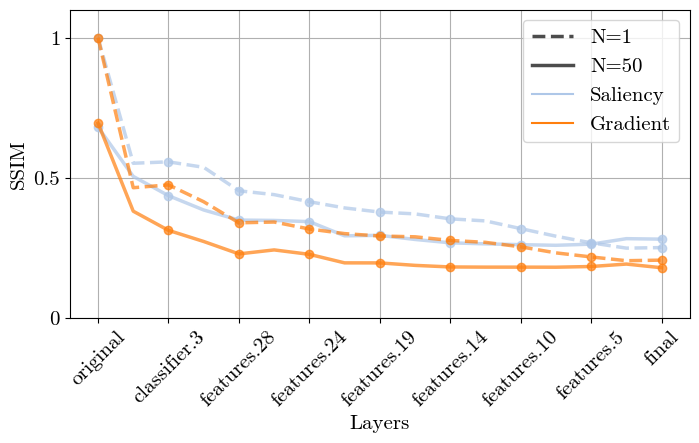

Plotting: Model vgg16, Randomisation Order bottom_up
['original', 'features.0', 'features.2', 'features.5', 'features.7', 'features.10', 'features.12', 'features.14', 'features.17', 'features.19', 'features.21', 'features.24', 'features.26', 'features.28', 'classifier.0', 'classifier.3', 'classifier.6']


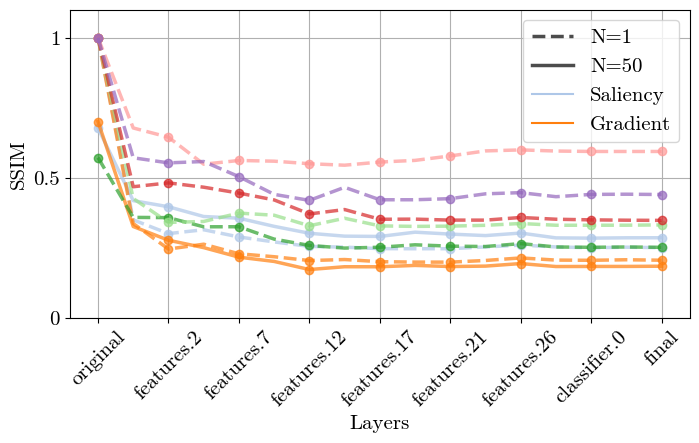

Plotting: Model resnet18, Randomisation Order top_down
['original', 'fc', 'layer4.1.bn2', 'layer4.1.conv2', 'layer4.1.bn1', 'layer4.1.conv1', 'layer4.0.downsample.1', 'layer4.0.downsample.0', 'layer4.0.bn2', 'layer4.0.conv2', 'layer4.0.bn1', 'layer4.0.conv1', 'layer3.1.bn2', 'layer3.1.conv2', 'layer3.1.bn1', 'layer3.1.conv1', 'layer3.0.downsample.1', 'layer3.0.downsample.0', 'layer3.0.bn2', 'layer3.0.conv2', 'layer3.0.bn1', 'layer3.0.conv1', 'layer2.1.bn2', 'layer2.1.conv2', 'layer2.1.bn1', 'layer2.1.conv1', 'layer2.0.downsample.1', 'layer2.0.downsample.0', 'layer2.0.bn2', 'layer2.0.conv2', 'layer2.0.bn1', 'layer2.0.conv1', 'layer1.1.bn2', 'layer1.1.conv2', 'layer1.1.bn1', 'layer1.1.conv1', 'layer1.0.bn2', 'layer1.0.conv2', 'layer1.0.bn1', 'layer1.0.conv1', 'bn1', 'conv1']


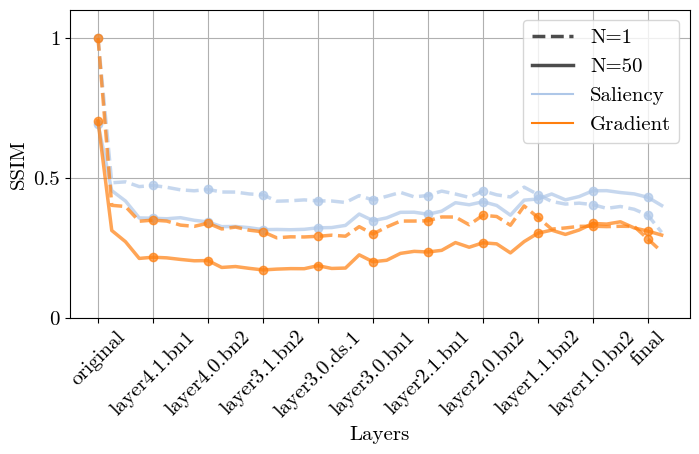

Plotting: Model resnet18, Randomisation Order bottom_up
['original', 'conv1', 'bn1', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1.conv1', 'layer4.1.bn1', 'layer4.1.conv2', 'layer4.1.bn2', 'fc']


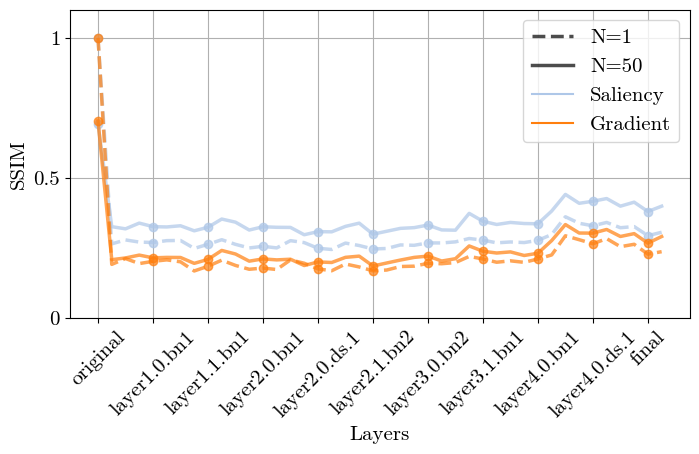

In [9]:
for mod_name, mod_res in results.items():

    for l, l_order in enumerate(HATCH_MAP.keys()):

        if l_order not in mod_res.keys():
            continue
        l_res = mod_res[l_order]

        print(f"Plotting: Model {mod_name}, Randomisation Order {l_order}")

        layer_names = l_res["layer_names"]

        fig, ax = plt.subplots(figsize=(8, 4))

        ax.set_xlabel("Layers")
        ax.set_ylabel("SSIM")
        ax.set_xticks([])
        ax.grid(True)
        ax.set_ylim([0.0, 1.1])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1])

        # xticklabels depend on model
        markevery=4 if "resnet" in mod_name else 2
        ax.set_xticks(list(range(len(layer_names)))[::markevery])
        xticklabels = layer_names[::markevery]
        for i in range(len(xticklabels)):
            xticklabels[i] = xticklabels[i].replace("downsample", "ds")
        xticklabels = xticklabels[:-1]+["final"]
        ax.set_xticklabels(xticklabels, rotation=45)

        for m, meth_name in enumerate(COLOR_MAP.keys()):

            for n, n_samp in enumerate(LINESTYLE_MAP.keys()):

                if n_samp not in l_res.keys():
                    continue
                n_res = l_res[n_samp]
                if meth_name not in n_res.keys():
                    continue
                res = n_res[meth_name]

                data = np.array(res)
                color = COLOR_MAP[meth_name]
                linestyle = LINESTYLE_MAP[n_samp]

                means = np.mean(data, axis=1)
                stds = np.std(data, axis=1)

                ax.plot(
                    list(range(len(means))), 
                    means, 
                    alpha=0.7, 
                    linewidth=linewidth, 
                    marker="o", 
                    markevery=markevery, 
                    linestyle=linestyle, 
                    color=color
                    )

        # Make Legend
        leg_lines = []
        LS_keys = [ls for ls in LINESTYLE_MAP.keys() if ls in l_res.keys()]
        for l in LS_keys:
            label = f"N={l}"
            leg_lines.append(ax.plot([], [], color="black", alpha=0.7, linewidth=linewidth, label=label, linestyle=LINESTYLE_MAP[l]))
        MK_KEYS = [mk for mk in COLOR_MAP.keys() if mk in n_res.keys()]
        for m in MK_KEYS:
            label=f"{m}"
            leg_lines.append(ax.plot([], [], color=COLOR_MAP[m], label=label, alpha=0.7, linewidth=linewidth))
        ax.legend()

        fig.savefig(os.path.join(savepath, f"sMPRT-lines-{mod_name}-{l_order}.svg"))

        plt.show()


### MPRT - randomisation order comparison lineplots (including accuracy)

Plotting: Model vgg16, Randomisation Order top_down


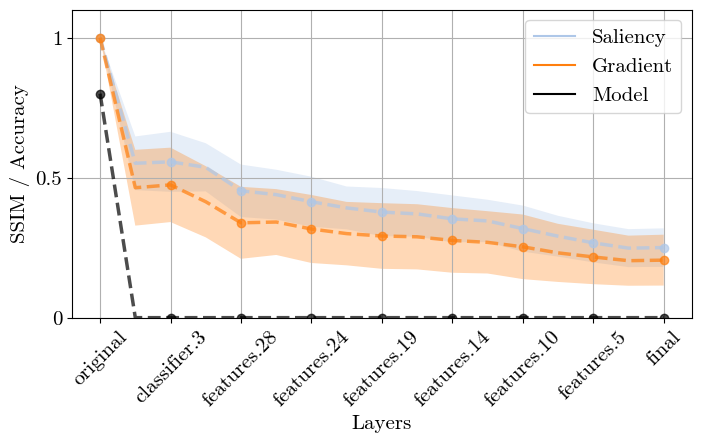

Plotting: Model vgg16, Randomisation Order bottom_up


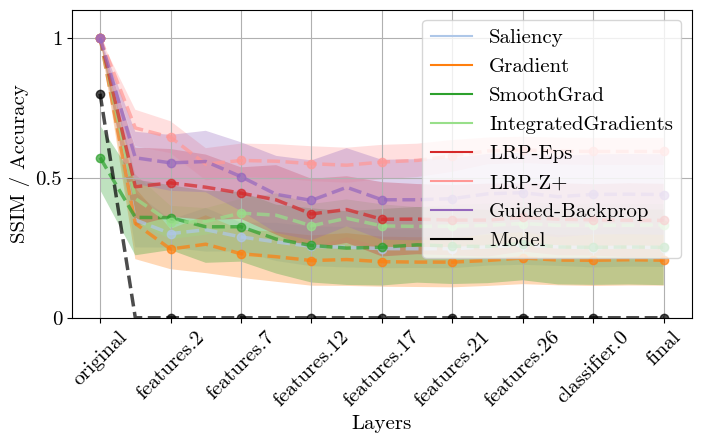

Plotting: Model resnet18, Randomisation Order top_down


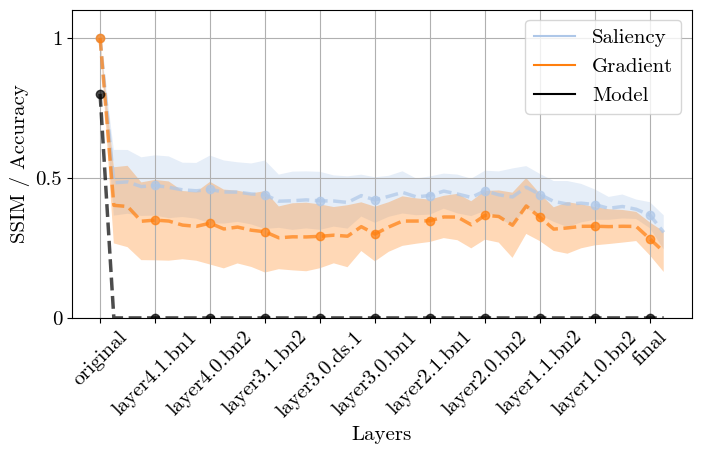

Plotting: Model resnet18, Randomisation Order bottom_up


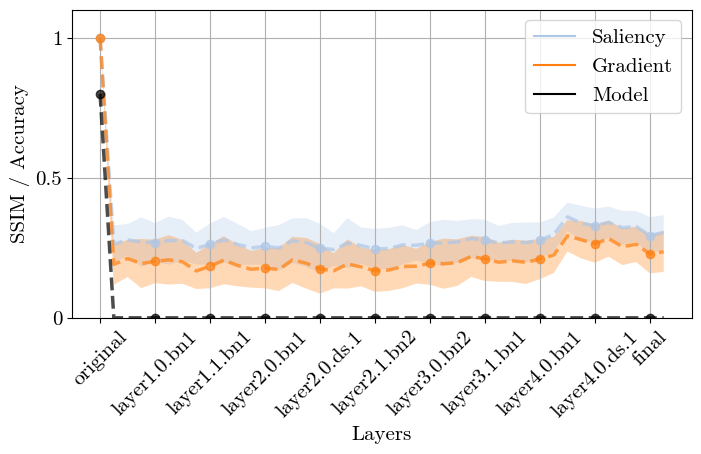

In [15]:
for mod_name, mod_res in results.items():

    for l, l_order in enumerate(HATCH_MAP.keys()):

        print(f"Plotting: Model {mod_name}, Randomisation Order {l_order}")

        if l_order not in mod_res.keys():
            continue
        l_res = mod_res[l_order]

        layer_names = l_res["layer_names"]

        fig, ax = plt.subplots(figsize=(8, 4))

        ax.set_xlabel("Layers")
        ax.set_ylabel("SSIM / Accuracy")
        ax.set_xticks([])
        ax.grid(True)
        ax.set_ylim([0.0, 1.1])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1])

        # xticklabels depend on model
        if "resnet" in mod_name:
            markevery=4
        else:
            markevery=2
        ax.set_xticks(list(range(len(layer_names)))[::markevery])
        xticklabels = layer_names[::markevery]
        ax.set_xticklabels(layer_names[::markevery])
        for i in range(len(xticklabels)):
            xticklabels[i] = xticklabels[i].replace("downsample", "ds")
        xticklabels = xticklabels[:-1]+["final"]
        ax.set_xticklabels(xticklabels, rotation=45)

        # Plot Methods
        for m, meth_name in enumerate(COLOR_MAP.keys()):

            for n, n_samp in enumerate(["1"]):

                if n_samp not in l_res.keys():
                    continue
                n_res = l_res[n_samp]
                if meth_name not in n_res.keys():
                    continue
                res = n_res[meth_name]

                data = np.array(res)
                color = COLOR_MAP[meth_name]
                linestyle = LINESTYLE_MAP[n_samp]

                means = np.mean(data, axis=1)
                stds = np.std(data, axis=1)

                ax.plot(
                    list(range(len(means))), 
                    means, 
                    alpha=0.7, 
                    linewidth=linewidth, 
                    marker="o", 
                    markevery=markevery, 
                    linestyle=linestyle, 
                    color=color
                    )
                ax.fill_between(
                    list(range(len(means))), 
                    means+stds, 
                    means-stds, 
                    facecolor=color, 
                    alpha=0.3
                    )

        # Plot Accuracy
        acc_res = l_res["accuracy"]

        data = np.array(acc_res)
        color = COLOR_MAP["Model"]
        linestyle = LINESTYLE_MAP["1"]

        ax.plot(
            list(range(len(data))), 
            data, 
            alpha=0.7, 
            linewidth=linewidth, 
            marker="o", 
            markevery=markevery, 
            linestyle=linestyle, 
            color=color
            )


        # Make Legend
        leg_lines = []
        MK_KEYS = [mk for mk in COLOR_MAP.keys() if mk in n_res.keys()]+["Model"]
        for m in MK_KEYS:
            label=f"{m}"
            leg_lines.append(ax.plot([], [], color=COLOR_MAP[m], label=label, alpha=0.7, linewidth=linewidth))
        ax.legend()

        fig.savefig(os.path.join(savepath, f"sMPRT-layerordercomparison-{mod_name}-{l_order}.svg"))

        plt.show()

### sMPRT - comparison of different N

Plotting: Model vgg16, Randomisation Order top_down


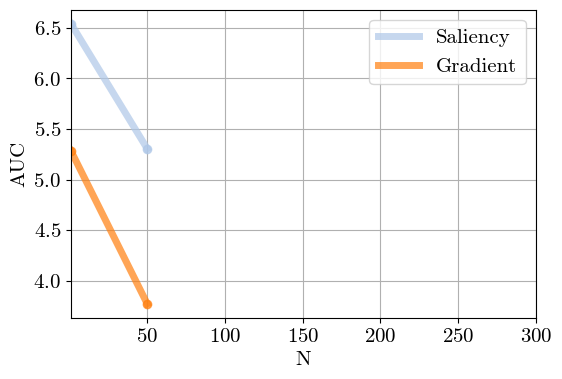

Plotting: Model vgg16, Randomisation Order bottom_up


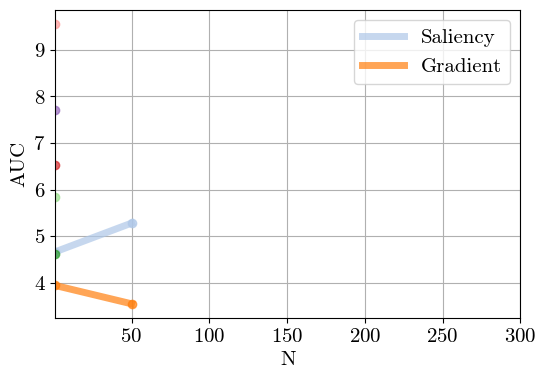

Plotting: Model resnet18, Randomisation Order top_down


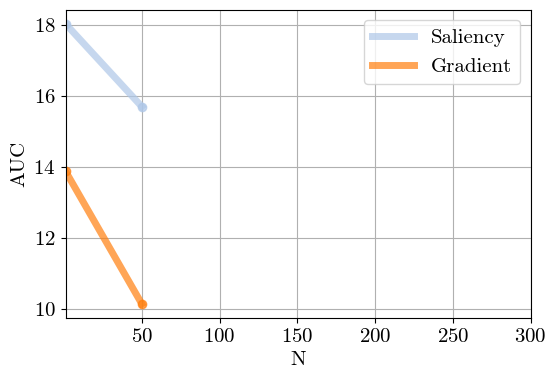

Plotting: Model resnet18, Randomisation Order bottom_up


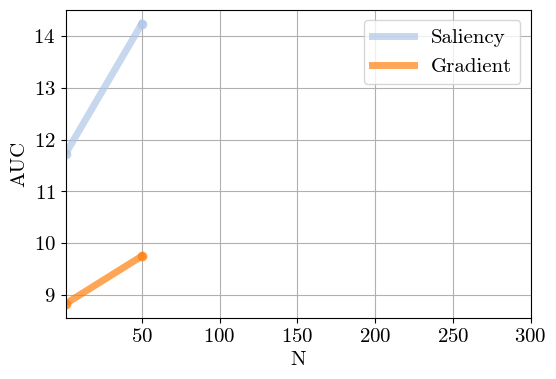

In [23]:
for mod_name, mod_res in results.items():

    for l, l_order in enumerate(HATCH_MAP.keys()):

        if l_order not in mod_res.keys():
            continue
        l_res = mod_res[l_order]

        print(f"Plotting: Model {mod_name}, Randomisation Order {l_order}")

        layer_names = l_res["layer_names"]

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.set_xlabel("N")
        ax.set_ylabel("AUC")
        ax.grid(True)
        ax.set_xlim((1, 300))

        for m, meth_name in enumerate(COLOR_MAP.keys()):

            means = []
            stds = []
            n_samps = []

            for n, n_samp in enumerate(l_res.keys()):

                if n_samp not in l_res.keys() or n_samp in ["layer_names", "accuracy"]:
                    continue
                n_res = l_res[n_samp]
                if meth_name not in n_res.keys():
                    continue
                res = n_res[meth_name]

                data = np.array(res)
                color = COLOR_MAP[meth_name]

                aucs = np.trapz(data, axis=0)
                auc_min = np.min(aucs)
                auc_25 = np.percentile(aucs, q=25)
                auc_50 = np.percentile(aucs, q=50)
                auc_75 = np.percentile(aucs, q=75)
                auc_max = np.max(aucs)
                color = COLOR_MAP[meth_name]

                means += [np.mean(aucs)]
                stds += [np.std(aucs)]
                n_samps += [int(n_samp)]

            ax.plot(
                n_samps, 
                means, 
                alpha=0.7, 
                linewidth=linewidth*2, 
                marker="o", 
                color=color
                )

        # Make Legend
        leg_lines = []
        MK_KEYS = [mk for mk in COLOR_MAP.keys() if mk in n_res.keys()]
        for m in MK_KEYS:
            label=f"{m}"
            leg_lines.append(ax.plot([], [], color=COLOR_MAP[m], label=label, alpha=0.7, linewidth=linewidth*2))
        ax.legend()

        fig.savefig(os.path.join(savepath, f"sMPRT-Ncomparison-{mod_name}-{l_order}.svg"))

        plt.show()